In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from io import BytesIO
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import requests
from PIL import Image, ImageDraw, ImageFont
from datasets import load_dataset

from yolo_model import YoloPretraining, YoloDetection
from imagenet import get_train_val_aug as imagenet_get_train_val_aug
from pascalvoc import (
    get_train_val_test_aug as pascalvoc_get_train_val_test_aug,
    get_pascal_voc_mapping,
)
from utils import (
    convert_yolo_to_pascalvoc,
    get_best_iou,
    split_yolo_tensor,
    nms,
    Color,
    resize_min_side,
)

# Test yolo backbone

In [3]:
# load everything
pretrained_path = Path("accelerate_logs/exp_2023-08-02_17-49-37/checkpoints/checkpoint_27/pytorch_model.bin")
bb_model = YoloPretraining(n_classes=1000).eval()
bb_model.load_state_dict(torch.load(pretrained_path, map_location="cpu"))
_, bb_val_aug = imagenet_get_train_val_aug()
classnames = load_dataset("evanarlian/imagenet_1k_resized_256", split="val").features["label"]

Found cached dataset parquet (/home/evan/.cache/huggingface/datasets/evanarlian___parquet/evanarlian--imagenet_1k_resized_256-351ca9e3a57965e9/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [4]:
def download_pil(url: str):
    imbytes = requests.get(url).content
    return Image.open(BytesIO(imbytes)).convert("RGB")

In [5]:
def predict_topk(model, id2name, val_aug, k, url):
    # download_image
    pil_image = download_pil(url)
    array_image = np.array(pil_image)
    plt.figure(figsize=(6, 3))
    plt.imshow(array_image)
    plt.axis("off")
    plt.show()
    # predict
    image_tensor = val_aug(image=array_image)["image"].unsqueeze(0)
    with torch.no_grad():
        pred = model(image_tensor).squeeze(0).softmax(-1)
    probs, indices = pred.topk(k)
    for prob, idx in zip(probs.tolist(), indices.tolist()):
        print(f"{prob:.4f}", id2name.int2str(idx))

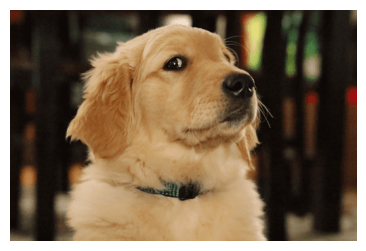

0.9643 golden retriever
0.0145 Labrador retriever
0.0136 cocker spaniel, English cocker spaniel, cocker
0.0016 tennis ball
0.0014 kuvasz


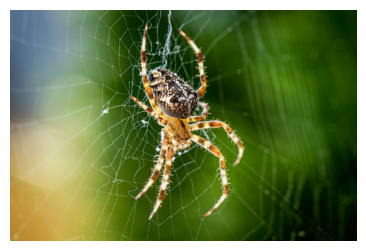

0.9315 garden spider, Aranea diademata
0.0510 spider web, spider's web
0.0097 barn spider, Araneus cavaticus
0.0078 black and gold garden spider, Argiope aurantia
0.0000 wolf spider, hunting spider


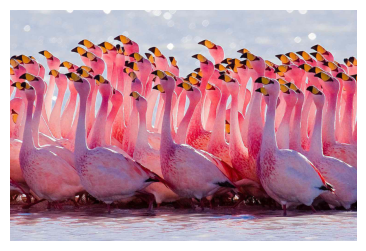

0.1750 bathing cap, swimming cap
0.1473 banana
0.0752 lionfish
0.0676 coral fungus
0.0490 artichoke, globe artichoke


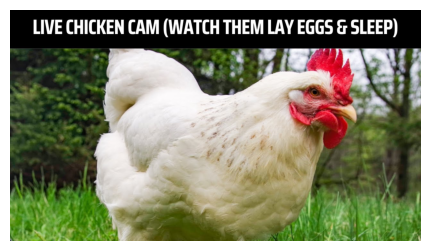

0.4309 hen
0.3527 white stork, Ciconia ciconia
0.1631 spoonbill
0.0240 sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita
0.0177 cock


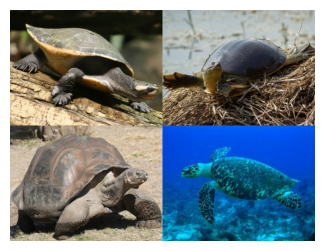

0.5164 terrapin
0.1156 loggerhead, loggerhead turtle, Caretta caretta
0.0989 box turtle, box tortoise
0.0589 snail
0.0490 leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea


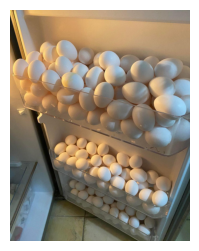

0.2047 Granny Smith
0.1793 rubber eraser, rubber, pencil eraser
0.0861 ping-pong ball
0.0854 carton
0.0745 confectionery, confectionary, candy store


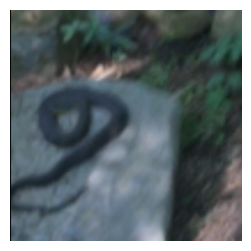

0.0766 skunk, polecat, wood pussy
0.0716 Siberian husky
0.0425 platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus
0.0347 ringneck snake, ring-necked snake, ring snake
0.0340 colobus, colobus monkey


In [6]:
URLS = [
    "https://global-uploads.webflow.com/59dbe1c3542805000192616b/63178a7970d1b57a4c6a7a05_golden-retriever.png",
    "https://www.ox.ac.uk/sites/files/oxford/field/field_image_main/shutterstock_garden%20cross%20spider_crop.jpg",
    "https://www.thespruce.com/thmb/mw-0Q-pFQ27CGwiiIFVgpIaUuaQ=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/puna-flamingo-58a6cb7d5f9b58a3c9fc5fc8.jpg",
    "https://i.ytimg.com/vi/McHENfPesH8/maxresdefault.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/2/21/Turtle_diversity.jpg",
    "https://pbs.twimg.com/media/EXmhMYqWAAA6trb.jpg",
    "https://i.redd.it/nz2zhypl2kgz.jpg",
]
for url in URLS:
    predict_topk(bb_model, classnames, bb_val_aug, k=5, url=url)

# Test yolo detection

In [7]:
# load everything
detection_path = Path("accelerate_logs/exp_2023-08-04_11-27-06/best_map.pt")
det_model = YoloDetection(B=2, C=20, use_sigmoid=True).eval()
det_model.load_state_dict(torch.load(detection_path, map_location="cpu"))
_, _, det_test_aug = pascalvoc_get_train_val_test_aug()
_, id2class = get_pascal_voc_mapping(Path("../../data/VOC2012/Annotations"))
color_tool = Color(len(id2class), "rainbow")

In [8]:
def detect_bbox(
    model, id2class, val_aug, url, color_tool, iou_thresh=0.5, conf_thresh=0.5, min_size=512
):
    # this whole procedure is only tested on batch size = 1
    image_pil = download_pil(url)
    # resize image so that the bbox will be nice to look at
    if min_size is not None:
        w, h = resize_min_side(*image_pil.size, min_size)
        image_pil = image_pil.resize((w, h))
    image_tensor = val_aug(image=np.array(image_pil))["image"].unsqueeze(0)
    with torch.no_grad():
        pred = model(image_tensor)
    bbox_pred, objectness_pred, class_pred = split_yolo_tensor(pred, S=7, B=2, C=20)
    bbox_pred = convert_yolo_to_pascalvoc(bbox_pred)  # yolo -> voc format

    # calculate nms, the confidence used is objectness pred
    kept_idx = nms(
        bbox_pred.reshape(-1, 4), objectness_pred.reshape(-1), iou_thresh=iou_thresh
    )

    # get overall box confidence
    max_class_value, max_class_indices = class_pred.max(-1, keepdims=True)
    overall_confidence = max_class_value * objectness_pred
    # need to expand because class is tied to cell, while confidence is tied to boxes
    max_class_indices = max_class_indices.expand_as(overall_confidence)

    # throw away boxes according to nms
    bbox_pred = bbox_pred.reshape(-1, 4)[kept_idx]
    overall_confidence = overall_confidence.reshape(-1)[kept_idx]
    max_class_indices = max_class_indices.reshape(-1)[kept_idx]

    # throw away boxes according to end user's conf_thresh
    conf_th_mask = overall_confidence >= conf_thresh
    bbox_pred = bbox_pred[conf_th_mask]
    overall_confidence = overall_confidence[conf_th_mask]
    max_class_indices = max_class_indices[conf_th_mask]

    # convert to real image coordinate
    bbox_pred[:, [0, 2]] *= w
    bbox_pred[:, [1, 3]] *= h

    # plot
    imdraw = ImageDraw.Draw(image_pil)
    font = ImageFont.truetype("UbuntuMono-B.ttf", 20)
    for box, conf, classid in zip(
        bbox_pred.tolist(), overall_confidence.tolist(), max_class_indices.tolist()
    ):
        outline = color_tool.get(classid)
        classname = id2class[classid]
        imdraw.rectangle(box, outline=outline, width=3)
        # anchor is where your text starts, encoded in "xy" code
        # ex: "lb" means box[0] is the (l)eft and box2 is the (b)ottom
        fbox = imdraw.textbbox(box[:2], classname, font=font, anchor="lb")
        imdraw.rectangle(fbox, fill=outline, width=3)
        imdraw.text(box[:2], classname, fill="black", font=font, anchor="lb")

    return image_pil

In [9]:
id2class

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

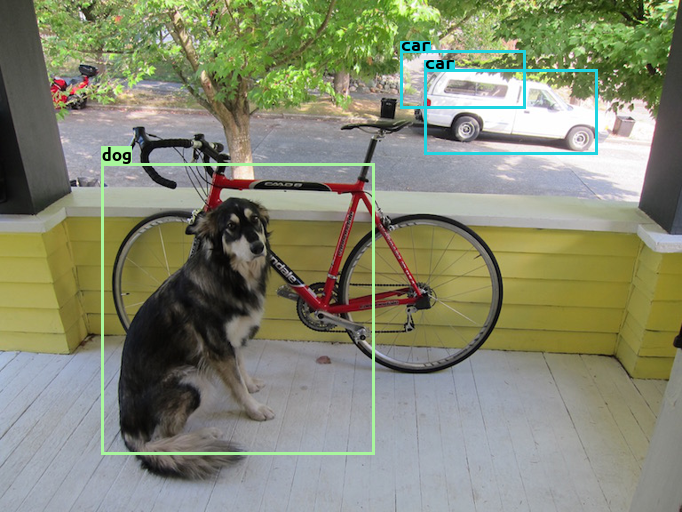

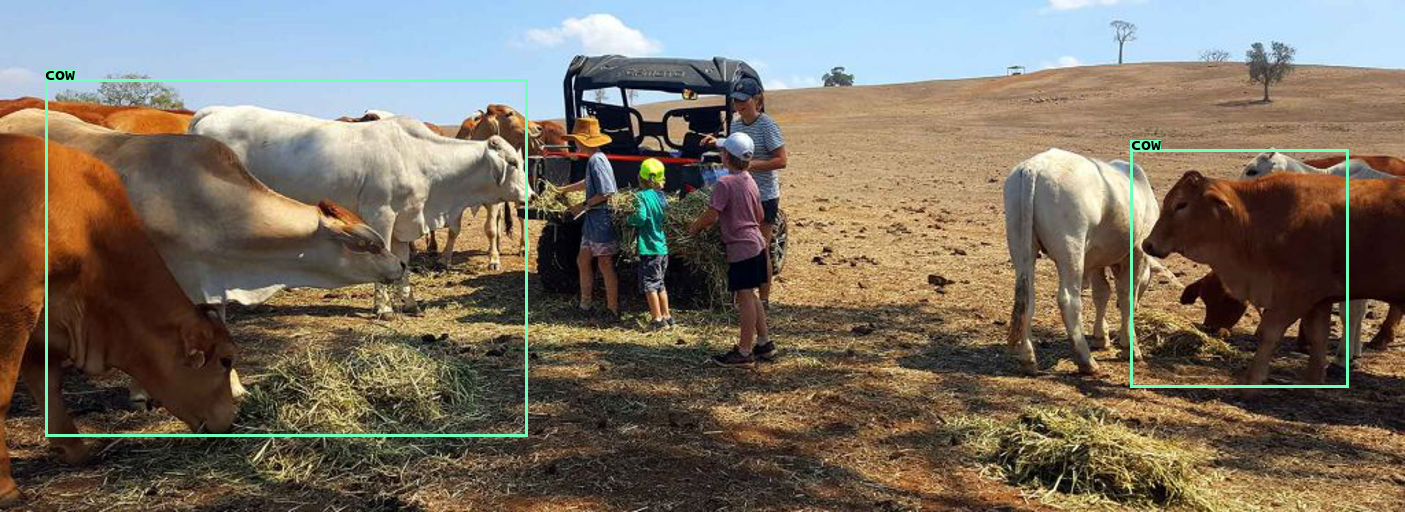

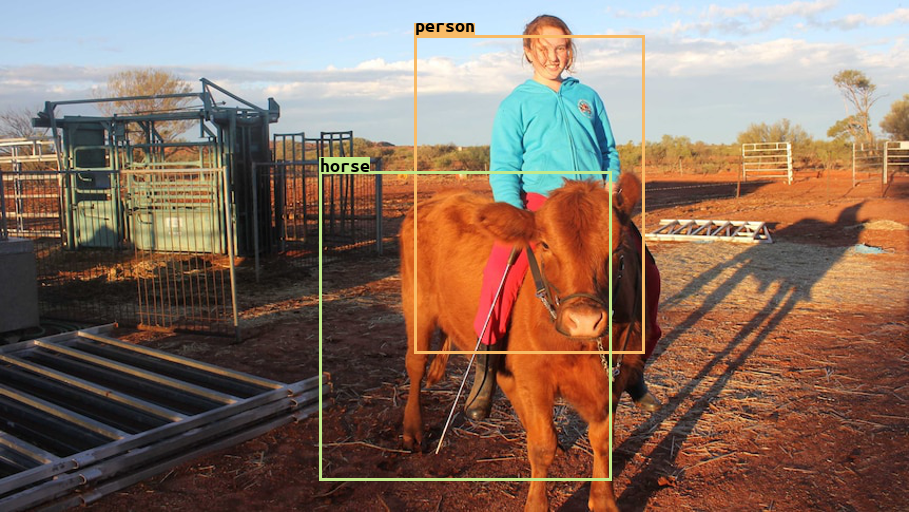

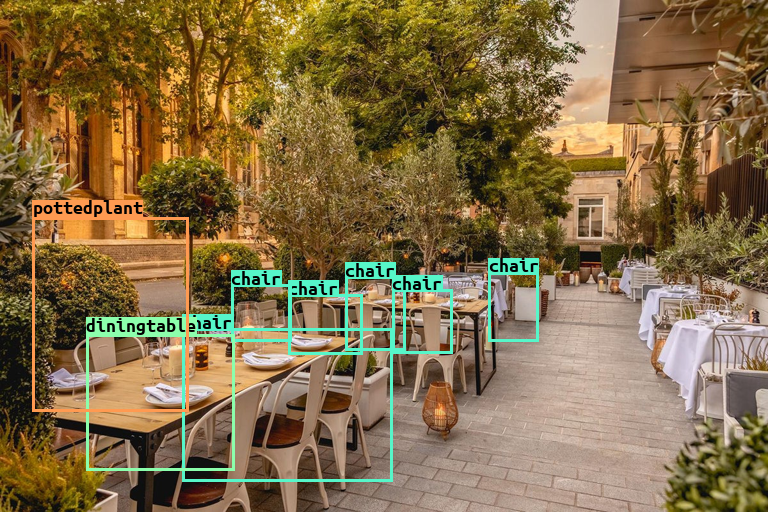

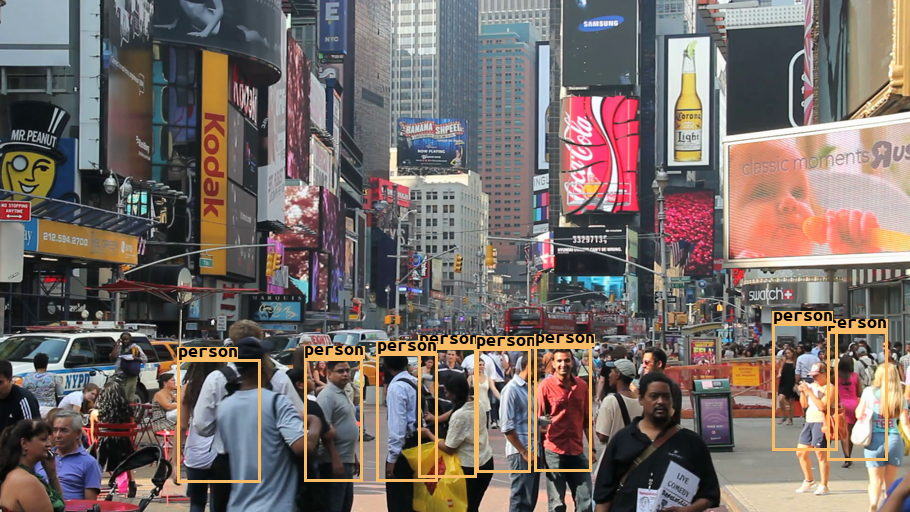

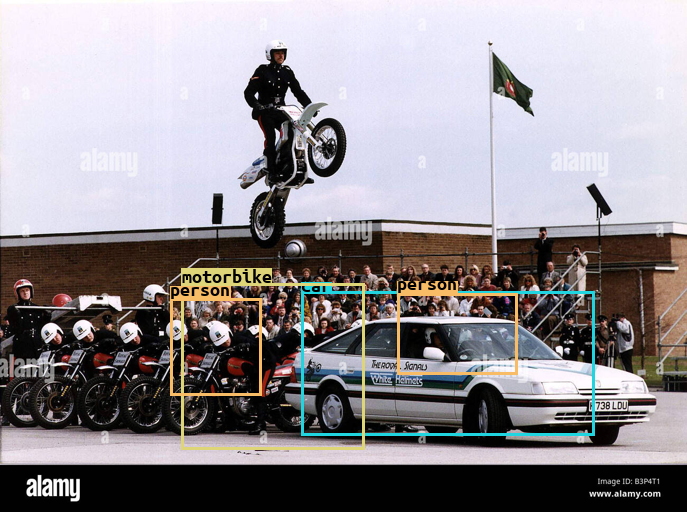

In [10]:
URLS = [
    "https://replicate.delivery/pbxt/ICdjEO98ocfguIXmE3CwKmSQCcloEdurvNLRW6fiffJuQTFA/1.jpg",
    "https://www.alkoomiadventurefarmstay.com.au/wp-content/uploads/2020/05/Feeding-Cattle-Activity-1024x373.jpg",
    "https://live-production.wcms.abc-cdn.net.au/6d78bf740b99887cb5ae745245a66b89?impolicy=wcms_crop_resize&cropH=1680&cropW=2983&xPos=17&yPos=317&width=862&height=485",
    "https://static.standard.co.uk/s3fs-public/thumbnails/image/2020/07/03/16/the-garden-at-the-berkeley-0307justin-de-souza.jpg?width=1200",
    "https://dm0qx8t0i9gc9.cloudfront.net/thumbnails/video/GTYSdDW/hustle-and-bustle-of-times-square_wyqtx7dgs_thumbnail-1080_01.png",
    "https://c8.alamy.com/comp/B3P4T1/army-regiments-royal-signals-white-helmets-on-motorbikes-doing-a-stunt-B3P4T1.jpg",
]

color_tool = Color(20, "rainbow")
for url in URLS[:]:
    result = detect_bbox(
        det_model,
        id2class,
        det_test_aug,
        url,
        color_tool,
        iou_thresh=0.3,  # iou thresh matters a lot
        conf_thresh=0.5,
        min_size=512,
    )
    display(result)